y = Theta

x = time
 
z = omega(angular velocity)

a = acceleration

g(x,y) is the derivative dy/dx

h is the stepsize

f_i is the value of y(x_i), so

f_ipo is the value of y(x_ipo).

## We import libraries

In [9]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML

## Defining our coupled derivatives to integrate

In [10]:
def dydx(x, y):
    
    # Set the derivatives
    
    # Our equation is d^2y/dx^2 = -A*sin(y)-B*z+C*sin(D*x)
    
    # So we can write
    #z = dydx
    #dzdx = -A*sin(y)-B*z+C*sin(D*x) = a
    
    # We will set a = y[0]
    # we will set z = y[1]
    
    # Declare an array
    y_derivs = np.zeros(2)
    
    # Set dydx = z
    y_derivs[0] = y[1]
    
    # Set dy^2dx^2 = a
    y_derivs[1] = -1*np.sin(y[0]) -0.5*y[1] + 0.5*np.sin((2/3)*x)
    
    # Here we have to return an array
    return y_derivs

## 4th order RK method

In [11]:
def rk4_mv_core(dydx, xi, yi, nv, h):
    
    # Declare k? arrays
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    
    # Define x at 1/2 step
    x_ipoh = xi +0.5*h
    
    # Define x at 1 step
    x_ipo = xi + h
    
    # Declare a temporary arrayy 
    y_temp = np.zeros (nv)
    
    # Get k1 values
    y_derivs = dydx(xi, yi)
    k1[:] = h*y_derivs[:]
    
    # Get k2 values
    y_temp[:] = yi[:] + 0.5*k1[:]
    y_derivs = dydx(x_ipoh, y_temp)
    k2[:] = h*y_derivs[:]
    
    # Get k3 values
    y_temp[:] = yi[:] + 0.5*k2[:]
    y_derivs = dydx(x_ipoh, y_temp)
    k3[:] = h*y_derivs[:]
    
    # Get k4 values
    y_temp[:] = yi[:] + k3[:]
    y_derivs = dydx(x_ipo, y_temp) #Why ipo and not ipoh?
    k4[:] = h*y_derivs[:]
    
    # Advance y by a step h
    yipo = yi + (k1 +2*k2 + 2*k3 + k4)/6.
    
    return yipo

## Adaptive step size driver for RK4

In [12]:
def rk4_mv_ad(dydx, x_i, y_i, nv, h, tol):

    #define safetyscale
    SAFETY = .9
    H_NEW_FAC = 2.
    
    #Set a maximum number of iterations
    imax = 10000
    
    #Set an iteration varale
    i = 0
    
    #Create an error
    Delta = np.full(nv, 2*tol)
    
    #Remember the step
    h_step = h
    
    #Adjust the step
    while (Delta.max()/tol > 1.0):
        # Estimate our error by taking one step of size  h
        #vs. two steps of the size h/2
        y_2 = rk4_mv_core(dydx, x_i, y_i, nv, h_step)
        y_1 = rk4_mv_core(dydx, x_i, y_i, nv, 0.5*h_step)
        y_11 = rk4_mv_core(dydx, x_i+0.5*h_step, y_1, nv, 0.5*h_step)
        
        
        # Always try to make every step bigger than the other,
        #but they are always correlated, not just an array of
        #numbers together
        
        #Compute an error
        Delta = np.fabs(y_2 - y_11)
        
        # If the error is too large, take a smaller step
        if (Delta.max()/tol > 1.0):
            #our error is too large, degrease the step
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
         
        #Check iteration
        if(i >= imax):
            print ('Too may iteratctions in rk4_mv_ad()')
            raise StopIteration ("Ending after i =", i)
            
        #iterate
        i += 1
        
    #next time, try to take a bigger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    #Return the answer, a new stap, and the step we actually took
    return y_2, h_new, h_step

## Wrapper for RK4

In [13]:
def rk4_mv(dydx, a, b, y_a, tol):
    
    #dydx is the derivative wrt x 
    #a is the lower bound
    #b is the upper bound
    #y_a are the boundary conditions
    #tol is the tolerance for integrating y
    
    #define our starting step
    xi = a
    yi = y_a.copy()
    
    #an initial step size == make very small
    h = 1.0e-4 * (b-a)
    
    #set max number of iterations
    imax = 10000
    
    #Set an iteration variable
    i = 0
    
    #Set the number of coupled odes to the
    #size of y_a
    nv = len(y_a)
    
    #Set the initial conditions
    x = np.full(1,a)
    y = np.full((1, nv), y_a)
    
    #Set a flag
    flag = 1
    
    #Loop until we reach the right side
    while(flag):
        #caluclate y_i + 1
        yi_new, h_new, h_step = rk4_mv_ad(dydx, xi, yi, nv, h, tol)
        
        #Update the step
        h = h_new
        
        #Prevent an overshoot
        if(xi+h_step > b):
            
            #take a smaller step
            h = b-xi
            
            #recalculate y_i+1
            yi_new, h_new, h_step = rk4_mv_ad(dydx, xi, yi, nv, h, tol)
            
            #break
            flag = 0
            
        #Update values
        xi += h_step
        yi[:] = yi_new[:]
        
        #add the step to the arrays
        x = np. append(x, xi)
        y_new = np.zeros((len(x), nv))
        y_new[0:len(x) - 1, :] = y
        y_new[-1, :] = yi[:]
        del y
        y = y_new
        
        #Prevent too many interactions
        if(i >= imax):
            print("MAximum iterations reachd.")
            raise StopIteration("Iteration number = ", i)
            
        #iterate
        i += 1
        
        #output some information
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb=%9.8f" % (i, xi, h_step, b)
        print(s)
        
        #Break if new xi is == b
        if (xi == b):
            flag = 0
            
    #return the answer
    return x, y

### Perform the integration

In [14]:
a = 0.0
b = 100.

#A
#B
#C
#D


y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

#Perform the integration
x, y = rk4_mv(dydx, a, b, y_0, tolerance)

i =   1	x = 0.01000000	h = 0.01000000	b=100.00000000
i =   2	x = 0.03000000	h = 0.02000000	b=100.00000000
i =   3	x = 0.07000000	h = 0.04000000	b=100.00000000
i =   4	x = 0.15000000	h = 0.08000000	b=100.00000000
i =   5	x = 0.31000000	h = 0.16000000	b=100.00000000
i =   6	x = 0.47255520	h = 0.16255520	b=100.00000000
i =   7	x = 0.63980647	h = 0.16725127	b=100.00000000
i =   8	x = 0.79852284	h = 0.15871637	b=100.00000000
i =   9	x = 0.95729848	h = 0.15877564	b=100.00000000
i =  10	x = 1.11670924	h = 0.15941076	b=100.00000000
i =  11	x = 1.27842739	h = 0.16171815	b=100.00000000
i =  12	x = 1.44331412	h = 0.16488673	b=100.00000000
i =  13	x = 1.61207060	h = 0.16875648	b=100.00000000
i =  14	x = 1.78517993	h = 0.17310933	b=100.00000000
i =  15	x = 1.96300292	h = 0.17782298	b=100.00000000
i =  16	x = 2.14583999	h = 0.18283708	b=100.00000000
i =  17	x = 2.33400895	h = 0.18816896	b=100.00000000
i =  18	x = 2.52791801	h = 0.19390906	b=100.00000000
i =  19	x = 2.72812437	h = 0.20020635	b=100.00

i = 154	x = 27.92214164	h = 0.20053055	b=100.00000000
i = 155	x = 28.11178010	h = 0.18963846	b=100.00000000
i = 156	x = 28.29657203	h = 0.18479193	b=100.00000000
i = 157	x = 28.47570751	h = 0.17913548	b=100.00000000
i = 158	x = 28.65105278	h = 0.17534527	b=100.00000000
i = 159	x = 28.82410086	h = 0.17304808	b=100.00000000
i = 160	x = 28.99674068	h = 0.17263982	b=100.00000000
i = 161	x = 29.16770468	h = 0.17096400	b=100.00000000
i = 162	x = 29.33756689	h = 0.16986221	b=100.00000000
i = 163	x = 29.50832180	h = 0.17075490	b=100.00000000
i = 164	x = 29.68105022	h = 0.17272842	b=100.00000000
i = 165	x = 29.85651274	h = 0.17546252	b=100.00000000
i = 166	x = 30.03500792	h = 0.17849518	b=100.00000000
i = 167	x = 30.21640026	h = 0.18139234	b=100.00000000
i = 168	x = 30.40018546	h = 0.18378520	b=100.00000000
i = 169	x = 30.58563123	h = 0.18544577	b=100.00000000
i = 170	x = 30.77193237	h = 0.18630114	b=100.00000000
i = 171	x = 30.95833083	h = 0.18639846	b=100.00000000
i = 172	x = 31.14419571	h = 

i = 321	x = 58.14095783	h = 0.17561734	b=100.00000000
i = 322	x = 58.31960661	h = 0.17864878	b=100.00000000
i = 323	x = 58.50113019	h = 0.18152358	b=100.00000000
i = 324	x = 58.68500903	h = 0.18387885	b=100.00000000
i = 325	x = 58.87050368	h = 0.18549465	b=100.00000000
i = 326	x = 59.05680916	h = 0.18630547	b=100.00000000
i = 327	x = 59.24317279	h = 0.18636364	b=100.00000000
i = 328	x = 59.42897290	h = 0.18580011	b=100.00000000
i = 329	x = 59.61378316	h = 0.18481025	b=100.00000000
i = 330	x = 59.79743751	h = 0.18365435	b=100.00000000
i = 331	x = 59.98009533	h = 0.18265782	b=100.00000000
i = 332	x = 60.16231201	h = 0.18221669	b=100.00000000
i = 333	x = 60.34514763	h = 0.18283561	b=100.00000000
i = 334	x = 60.53040127	h = 0.18525364	b=100.00000000
i = 335	x = 60.72122209	h = 0.19082082	b=100.00000000
i = 336	x = 60.92119087	h = 0.19996878	b=100.00000000
i = 337	x = 61.11051035	h = 0.18931948	b=100.00000000
i = 338	x = 61.29494450	h = 0.18443415	b=100.00000000
i = 339	x = 61.47381902	h = 

i = 487	x = 88.26251677	h = 0.18262322	b=100.00000000
i = 488	x = 88.44473411	h = 0.18221734	b=100.00000000
i = 489	x = 88.62763196	h = 0.18289786	b=100.00000000
i = 490	x = 88.81305185	h = 0.18541989	b=100.00000000
i = 491	x = 89.00423061	h = 0.19117876	b=100.00000000
i = 492	x = 89.20377067	h = 0.19954006	b=100.00000000
i = 493	x = 89.39286599	h = 0.18909532	b=100.00000000
i = 494	x = 89.57703921	h = 0.18417322	b=100.00000000
i = 495	x = 89.75572418	h = 0.17868496	b=100.00000000
i = 496	x = 89.93076396	h = 0.17503978	b=100.00000000
i = 497	x = 90.10368723	h = 0.17292327	b=100.00000000
i = 498	x = 90.27640300	h = 0.17271577	b=100.00000000
i = 499	x = 90.44711558	h = 0.17071257	b=100.00000000
i = 500	x = 90.61704116	h = 0.16992558	b=100.00000000
i = 501	x = 90.78796140	h = 0.17092024	b=100.00000000
i = 502	x = 90.96095132	h = 0.17298992	b=100.00000000
i = 503	x = 91.13672025	h = 0.17576893	b=100.00000000
i = 504	x = 91.31552303	h = 0.17880278	b=100.00000000
i = 505	x = 91.49718185	h = 

### Plot the results

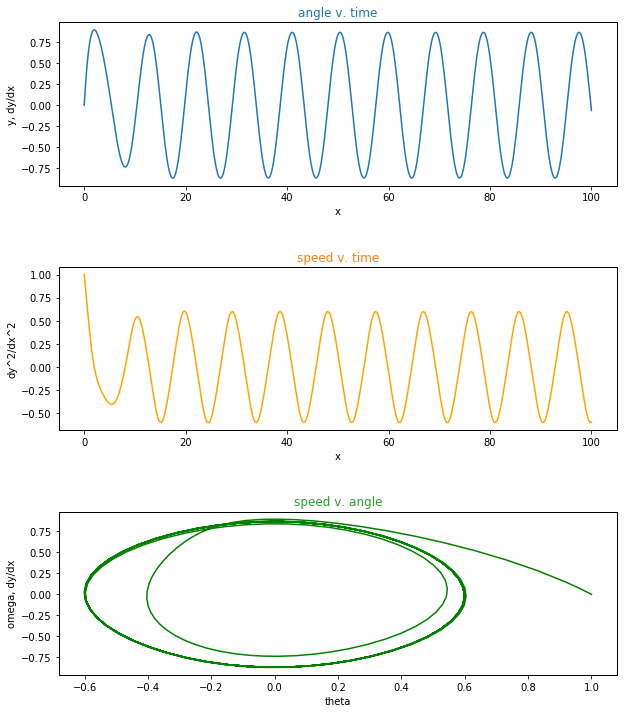

In [15]:
f, axarr = plt.subplots(3,1, figsize=(10,12))

axarr[0].plot(x, y[:,0], '-', label='y(x)')

axarr[0].set_xlabel('x')
axarr[0].set_ylabel('y, dy/dx')
axarr[0].set_title('angle v. time', color='C0')
axarr[0].axis()
#axarr[0].set_aspect(100)

axarr[1].plot(x, y[:,1], '-', color='orange', label='dydx(x)')
axarr[1].set_xlabel('x')
axarr[1].set_ylabel('dy^2/dx^2')
axarr[1].set_title('speed v. time', color='C1')

axarr[2].plot(y[:,1], y[:,0], '-', color='green', label='omega(theta)')

axarr[2].set_xlabel('theta')
axarr[2].set_ylabel('omega, dy/dx')
axarr[2].set_title('speed v. angle', color='C2')

f.subplots_adjust(wspace = 1.0)
#fig = plt.figure(figsize = (6,6))

'''Aesthetic edits to the plots'''

#change plots border width
plt.rcParams['axes.linewidth'] = 1 #set the value globally
#change distance between plots
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

### Plot the error

Notice that the errors will actually exceed our "tolerance".

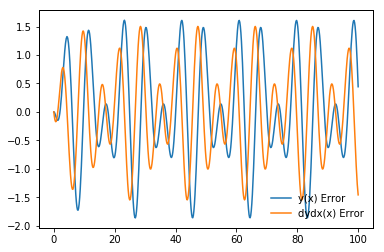

In [16]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0] - sine)
dydx_error = (y[:,1] - cosine)

plt.plot(x, y_error, label='y(x) Error')
plt.plot(x, dydx_error, label="dydx(x) Error")
plt.legend(frameon=False)